In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
import seaborn as sns
import hashlib
import swifter
from scipy import stats

# A/B тестирование

**Продукт:** лента новостей <br/>
**Структура данных:**<br/>
- user_id - уникальный номер пользователя
- likes - лайки
- views - просмотры
- ctr (likes/views) конверсия из просмотра в лайки <br/>

**Тест:** новый алгоритм рекомендации постов

## A/A тест

Задание 1: Делаем симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации нужно сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

In [44]:
connection = {'host': '***',
              'database':'***',
              'user':'***', 
              'password':'***'
                     }

In [45]:
q = '''
select exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from {db}.feed_actions
WHERE toDate(time) >= '2022-02-06' and toDate(time) <= '2022-02-12'
GROUP BY exp_group, user_id
'''
df = ph.read_clickhouse(q, connection=connection)

## АА-тест проходил в период с 2022-02-06 по 2022-02-12
### Сравниваем группу 1 и группу 2

In [46]:
df_1_2 = df.query("exp_group in (1,2)")
df_1_2.groupby('exp_group').mean().round(3)

,user_id,likes,views,ctr
exp_group,,,,
1,70528.231,15.426,73.764,0.216
2,69282.767,15.534,73.494,0.218


Посмотрим на распределение CTR в группах 1 и 2

In [48]:
print("Средний CTR в группе 1 :", df_1_2.query("exp_group == 1").ctr.mean().round(3))
print("Средний CTR в группе 2 :", df_1_2.query("exp_group == 2").ctr.mean().round(3))

Средний CTR в группе 1 : 0.216
Средний CTR в группе 2 : 0.218


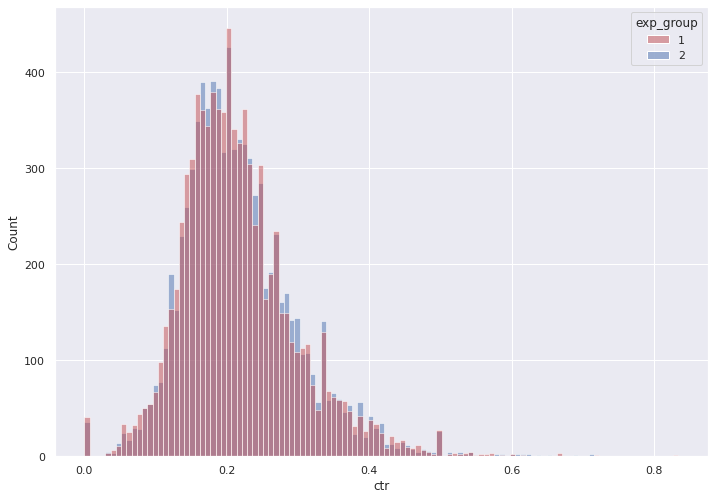

In [10]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df_1_2, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

### t-критерий Стьюдента
**Нулевая гипотеза H0: μ1 == μ2**

In [11]:
stats.ttest_ind(df_1_2[df_1_2.exp_group == 1].ctr,
                df_1_2[df_1_2.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=-2.017208642179449, pvalue=0.043689417475737895)

### Тест Манна-Уитни
**Нулевая гипотеза H0: P(X>Y) = P(Y>X)**

In [13]:
print(stats.mannwhitneyu(df_1_2[df_1_2.exp_group == 1].ctr,
                df_1_2[df_1_2.exp_group == 2].ctr))

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df_1_2[df_1_2.exp_group == 1].ctr.sample().values[0] > df_1_2[df_1_2.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=35494234.0, pvalue=0.028310380571668212)
В 49.44 % случаев A > B. Должно получиться около 50%


### Вывод
"На глаз" мы можем заметить, что группы "1" и "2" выглядят одинаковыми

С помощью t-критерия Стьюдента и теста Манна-Уитни мы также удостоверились, что АА-тест сходится, система сплитования работает корректно

Можем переходить к АВ-тесту 

## А/В-тест проходил в период с 2022-02-13 по 2022-02-19 включительно
### Сравниваем группу 1 и группу 2
*1 - Все по-старому* <br/>
*2 - Рекомендации похожих на лайкнутые постов*

In [49]:
q = '''
select exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from {db}.feed_actions
WHERE toDate(time) >= '2022-02-13' and toDate(time) <= '2022-02-19'
GROUP BY exp_group, user_id
'''
dfab = ph.read_clickhouse(q, connection=connection)

In [50]:
df_1_2 = dfab.query("exp_group in (1,2)")

In [52]:
print("Средний CTR в группе 1 :", df_1_2.query("exp_group == 1").ctr.mean().round(3))
print("Средний CTR в группе 2 :", df_1_2.query("exp_group == 2").ctr.mean().round(3))

Средний CTR в группе 1 : 0.216
Средний CTR в группе 2 : 0.214


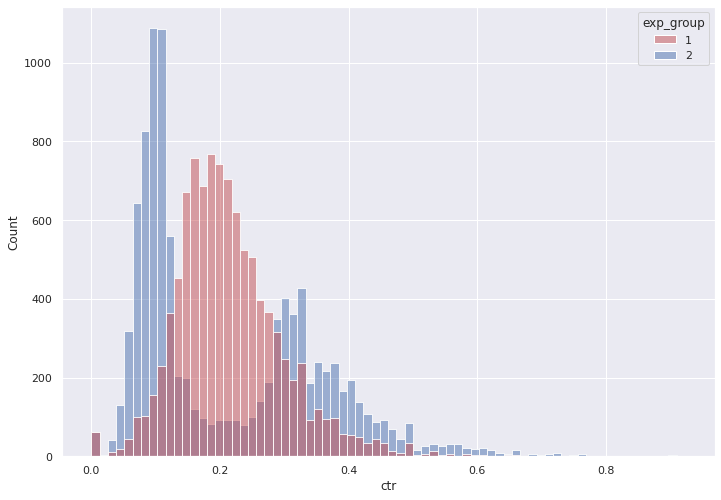

In [51]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df_1_2, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

### Бакетное преобразование

In [17]:
b = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) >= '2022-02-13' and toDate(time) <= '2022-02-19'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

bp = ph.read_clickhouse(b, connection=connection)

In [18]:
print(stats.mannwhitneyu(bp[bp.exp_group == 1].bucket_ctr, 
                   bp[bp.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided'))
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= bp[bp.exp_group == 1].bucket_ctr.sample().values[0] > bp[bp.exp_group == 2].bucket_ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A(группа 1) > B(группа 2). Должно получиться около 50%')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)
В 79.94 % случаев A(группа 1) > B(группа 2). Должно получиться около 50%


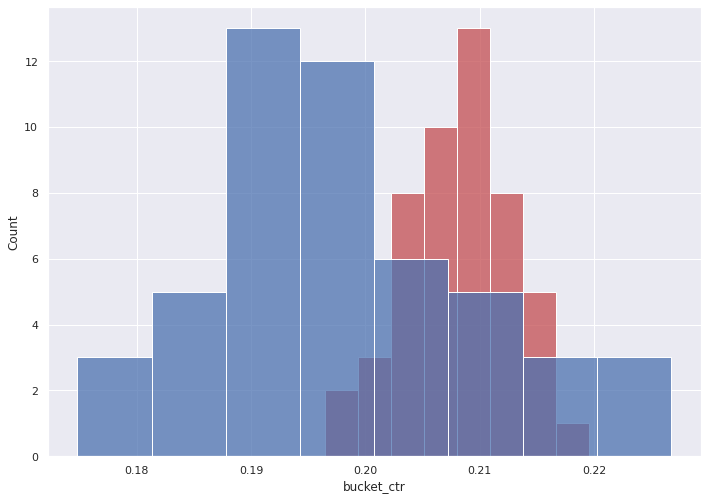

In [19]:
sns.histplot(bp[bp.exp_group == 1].bucket_ctr, color ='r')
sns.histplot(bp[bp.exp_group == 2].bucket_ctr,color ='b')

### Вывод
Анализ A/B теста проводился с помощью теста Манна-Уитни поверх бакетного преобразования <br/>
Различие в 2х группах статистически значимое, при этом почти в 80% случаев значения в контрольной группе выше, чем в тестовой. При этом СTR>0.3 выше в группе в тестовой группе. Возможно алгоритм хорошо работает на определенной тематике<br/>
Новый алгоритм на всех новых пользователей в данный момент выкатывать не стоит, но имеет смысл попробовать доработать алгоритм и повторить тест позже. 

## Проанализируем дополнительно тест между группами 1 и 2 по метрике линеаризованных лайков

In [24]:
q = '''
select exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from {db}.feed_actions
WHERE toDate(time) >= '2022-02-13' and toDate(time) <= '2022-02-19'
GROUP BY exp_group, user_id
'''
df = ph.read_clickhouse(q, connection=connection)

In [28]:
df_1_2 = df.query("exp_group in (1,2)")

**Считаем общий CTR в контрольной группе**  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)

In [25]:
CTRcontrol = sum(df.loc[df["exp_group"] == 1, "likes"])/sum(df.loc[df["exp_group"] == 1, "views"])
print(CTRcontrol)

0.20802680490126244


**Посчитаем в обеих группах поюзерную метрику**  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠

In [29]:
df_1_2['linearized_likes']=df_1_2['likes']-CTRcontrol*df_1_2['views']

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
df_1_2.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
1,1,18392,7,32,0.218750,0.343142
3,2,131473,14,134,0.104478,-13.875592
5,2,32420,26,128,0.203125,-0.627431
6,2,24239,40,90,0.444444,21.277588
8,1,27443,2,29,0.068966,-4.032777


#### Linearized likes

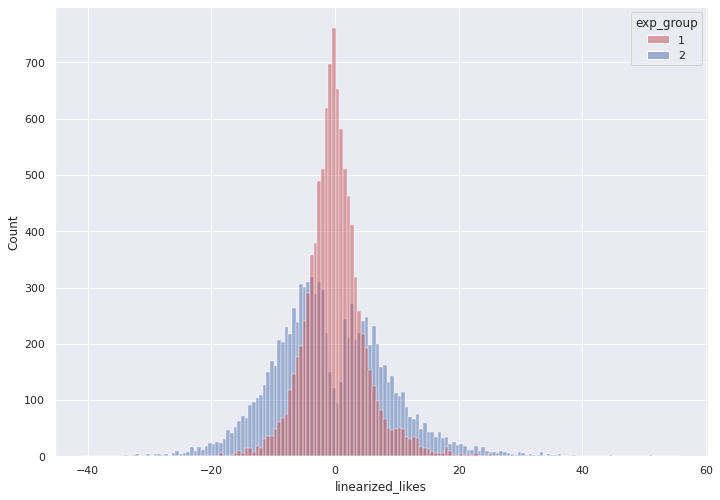

In [34]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df_1_2, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [35]:
stats.ttest_ind(df_1_2[df_1_2.exp_group == 1].linearized_likes,
                df_1_2[df_1_2.exp_group == 2].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775974, pvalue=9.439432187037644e-10)

### Вывод
При анализе линеаризованных лайков значение pvalue меньше, чем при анализе CTR